In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import yaml
import ast

In [2]:
%run ./src/database.py
%run ./src/util.py
%run ./src/data_preprocessing.py
%run ./src/feature_engineering.py
%run ./src/visualisation.py
%run ./src/model_build.py

In [3]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1
IS_NOTEBOOK = True

# Read yaml config and data

In [4]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)
DISPLAY_STUB = yaml_data['display_stub']
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']
DB_INFO = yaml_data['databases']
COMPOSITE_FIELD_INFO = yaml_data['composite_fields_to_split']
ID_FIELDS = ast.literal_eval(yaml_data['ID_columns'])
DATETIME_FIELD_INFO = yaml_data['convert_obj_datetime']
NUMERIC_FIELD_INFO = yaml_data['convert_obj_numeric']
MISSING_VAL_THRESHOLD =  yaml_data['pct_missing_threshold']
CONTINUOUS_VARIABLE = ast.literal_eval(yaml_data['continuous_variables'])
DIRTY_DATA_INFO = yaml_data['dirty_data_setting']
VALID_DATA_INFO = yaml_data['valid_data_setting']
NON_NUMERIC_COL = yaml_data['non_numeric_cols']
DATE_YYYY_INFO = yaml_data['convert_date_yyyy']

In [5]:
# Read Pre_cruise data
df_pre_cruise = db_read(DATA_PATH, DB_INFO[PRE_CRUISE_DB])

In [6]:
# Read Post_cruise data
df_post_cruise = db_read(DATA_PATH, DB_INFO[POST_CRUISE_DB])

# Preprocessing

In [7]:
# Merge Pre_cruise and Post_cruise to form df_cruise with Index as the key
df_cruise = db_merge_db (df_pre_cruise, df_post_cruise)

In [8]:
dp = DataProcessing(df_cruise, DISPLAY_STUB)

In [9]:
# Replace all np.nan to None
dp.replace_nan_none()

In [10]:
# Split composite field
dp.split_composite_field(COMPOSITE_FIELD_INFO)

In [11]:
# Remove IDs columns as in general they will have no predictive power
dp.rm_id_cols(ID_FIELDS)

In [12]:
# Column pruning due to high missing values.
dp.rm_cols_high_missing(MISSING_VAL_THRESHOLD)

In [13]:
# Convert fields from Object to Datetime
dp.obj_to_datetime(DATETIME_FIELD_INFO)

In [14]:
# Convert fields from Object to Numeric 
dp.numeric_conversion(NUMERIC_FIELD_INFO)

In [15]:
# Remove of rows from Target Variable 
dp.rm_rows_target_var(TARGET_VARIABLE)

In [16]:
# Removal of rows from Continuous variable which has missing value 
dp.remove_missing(CONTINUOUS_VARIABLE)

In [17]:
# Dirty Data Cleansing
dp.dirty_data_processing(DIRTY_DATA_INFO)

In [18]:
# Restriction of Column vales
dp.valid_data_processing(VALID_DATA_INFO)

In [19]:
# Label encode non-numeric categorical columns to get numeric values
dp.label_encoder(NON_NUMERIC_COL)

In [20]:
# Derive year from date column to enhance model efficiency, mitigate noise
dp.yyyy_from_date(DATE_YYYY_INFO)

# Feature Engineering

In [21]:
fe = feature_engineering(dp.get_dataframe())

In [22]:
# Standardise distance by converting Mile to KM
fe.convert_miles_to_KM("Distance")

In [23]:
# Derive Age from Year of Birth and Year of Logging
fe.calc_year_diff('Year of Logging', 'Year of Birth', 'Age')

In [24]:
# Compute number of column
# fe.denote_missing_col()

#### Gender

In [25]:
# fe.impute_missing_value(impute_type="random", col_list=['Gender'], none_val=2)

In [26]:
fe.impute_missing_value(impute_type="mean")

# Model Building

In [27]:
lr = Logistic_Regression(fe.get_dataframe())


In [28]:
X, y = lr.prepare_data(TARGET_VARIABLE)

In [29]:

# columns = X_train.columns
# os_data_X,os_data_y=os.fit_resample(X_train, y_train)
# os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
# os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])


Classification Report 
Train 
              precision    recall  f1-score   support

           0       0.62      0.71      0.66     31625
           1       0.73      0.68      0.70     31625
           2       0.61      0.56      0.58     31625

    accuracy                           0.65     94875
   macro avg       0.65      0.65      0.65     94875
weighted avg       0.65      0.65      0.65     94875

Test 
              precision    recall  f1-score   support

           0       0.13      0.36      0.19      1279
           1       0.80      0.69      0.74      7844
           2       0.69      0.57      0.63      7404

    accuracy                           0.61     16527
   macro avg       0.54      0.54      0.52     16527
weighted avg       0.70      0.61      0.65     16527


Confusion Metric
Train


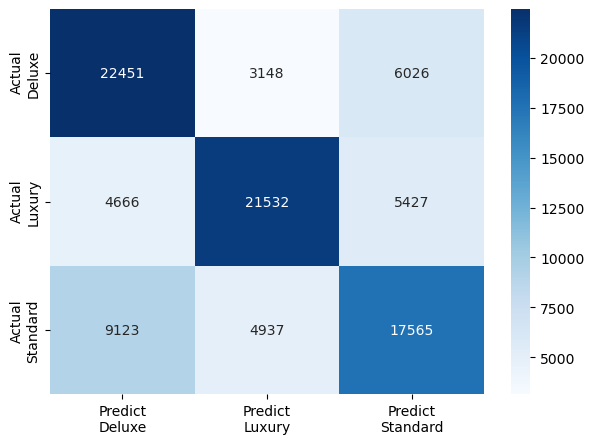

Test


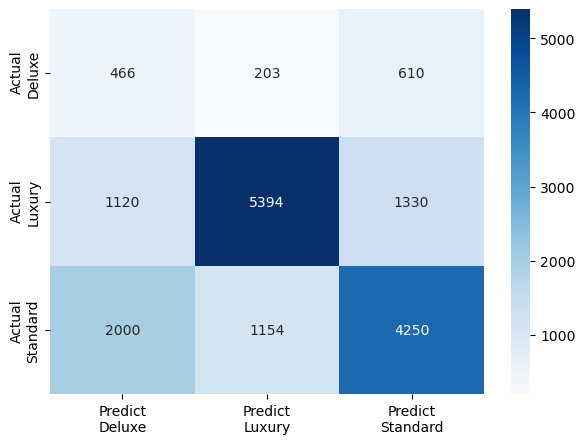


Performance Metrics
Train 
Test Accuracy: 0.6487
Test Precision: 0.6487
Test Recall: 0.6487
Test 
Test Accuracy: 0.6117
Test Precision: 0.6117
Test Recall: 0.6117


In [30]:
hyperparameter_dict = {
    'random_state': RANDOM_STATE,
    'max_iter': 10000
}

lr.model_processing(X, y, TEST_SIZE, RANDOM_STATE, hyperparameter_dict, IS_NOTEBOOK)

# Model Evaluation

In [31]:
# from sklearn import metrics
# print("Classification report - Train")
# print(classification_report(y_train, y_train_pred_log))
# print("Classification report - Test")
# print(classification_report(y_test, y_test_pred_log))
# print(" ")
# print("Classification report - Test")
# print(confusion_matrix(y_train, y_train_pred_log))
# print("Confusion Matrix - Test")
# print(confusion_matrix(y_test, y_test_pred_log))
# print(" ")
# print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_log), '.4f'))
# # print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# # print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# # print(" ")
# print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_log), '.4f'))
# # print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# # print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

# print("")


In [32]:
# from sklearn import metrics
# print("Classification report - Train")
# print(classification_report(y_train, y_train_pred_rf))
# print("Classification report - Test")
# print(classification_report(y_test, y_test_pred_rf))
# print(" ")
# print("Classification report - Test")
# print(confusion_matrix(y_train, y_train_pred_rf))
# print("Confusion Matrix - Test")
# print(confusion_matrix(y_test, y_test_pred_rf))
# print(" ")
# print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_rf), '.4f'))
# # print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# # print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# # print(" ")
# print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_rf), '.4f'))
# # print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# # print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

# print("")
